In [1]:
# pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import ViTImageProcessor, ViTForImageClassification
import torch
import torch.nn.functional as F
import shap

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from utils import tokenize_input, plot_attention_weights, get_model_pred
#from grad_sam import grad_sam
#from shap_values import shap_values
from tcav import select_concept_images, sample_images, get_vit_dataloader, flatten, get_activations, get_grads, train_cav, tcav

/home/emmanuel-olateju/AIMS/XAI/AIMS.XAI.Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device {device}")

seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True 

Using device cpu


In [3]:
# Use BERT trained on the SST-2 dataset (for binary classification)
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2",attn_implementation="eager").to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Grad-SAM

In [4]:
def display_token_importance(tokens, importance):
    sorted_ = sorted(list(zip(tokens, importance)), key=lambda x: x[1], reverse=True) 

    for i, (token, value) in enumerate(sorted_, start=1):
        print(f"{i}. '{token}': {value:.8f}")

def plot_token_importance(tokens, scores, title="Token importance (Grad-CAM)"):
    scores = scores - scores.min()
    if scores.max() > 0:
        scores = scores / scores.max()

    fig, ax = plt.subplots(figsize=(len(tokens) * 0.7, 2))

    ax.imshow(scores[np.newaxis, :], aspect="auto", cmap="Reds")
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.set_yticks([])
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [5]:
def get_grads_gradsam(model, attentions, logits): 
    """Return the gradient of the output with respect to the attention weights for all heads in all layers."""

    n_layers = model.config.num_hidden_layers

    pred = get_model_pred(logits)
    logits = logits.squeeze()

    attention_grads = {layer_idx : None for layer_idx in range(n_layers)} 

    # Retain gradients for attention matrices
    for att in attentions:
        att.retain_grad()

    model.zero_grad()

    # Backward from the model prediction 
    logits[pred].backward(retain_graph=True)  

    # Collect gradients for each layer
    for layer_idx, att in enumerate(attentions):
        grad = att.grad.squeeze().clone() # Shape (n_heads, seq_len, seq_len)
        attention_grads[layer_idx] = grad
    
    return attention_grads

### Homework: Write the Grad-SAM function

In [7]:
model.config

BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "finetuning_task": "sst-2",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.6",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [9]:
def grad_sam(model, attentions, logits):
    """Returns the Grad-SAM score for all tokens in an input sequence."""

    model = model.to(device)

    n_heads = model.config.num_attention_heads # number of attention heads
    n_layers = model.config.num_hidden_layers # number of hidden layers

    attention_grads = get_grads_gradsam(model, attentions, logits)

    seq_len = attentions[0].shape[-1]  # find sequence length from attentions, including CLS and SEP tokens are included

    layer_vectors = []

    for layer_idx, grad in attention_grads.items():
        relu_grad = F.relu(grad) # take the relu of the gradient # Shape (n_heads, seq_len, seq_len)

        attention = attentions[layer_idx].squeeze().detach() # get attentions for the layer # Shape (n_heads, seq_len, seq_len)

        hadamard_product = relu_grad * attention # do the multiplication from the equation

        summed_columns = hadamard_product.sum(dim=-1) # Sum attention weights for each head (sum over columns) # Shape (n_heads, seq_len)

        summed_heads = summed_columns.sum(dim=0) # Sum over all heads # Shape (seq_len)

        # append summed_heads to the layer_vectors
        layer_vectors.append(summed_heads)

    grad_sam_scores = torch.stack(layer_vectors).sum(dim=0) # sum over the layer_vectors
    grad_sam_scores = (grad_sam_scores - grad_sam_scores.min()) / (grad_sam_scores.max() - grad_sam_scores.min() + 1e-8) # normalise
            
    return grad_sam_scores 

In [10]:
sentences = ["I like the movie",
            "She hates the book",
            "This is so boring",
            "I cannot wait for next time",
            "You look extremely confused"
            ]

for sentence in sentences:
    # Return the tokenizer output for the input sentence, which includes the tokenized sentences with
    # added CLS and SEP tokens and the attention masks 
    input = tokenize_input(tokenizer, sentence).to(device)
    output = model(**input, output_attentions=True) # Forward pass 
    logits = output.logits
    pred = get_model_pred(logits)

    # Get attention matrices for all heads and layers 
    attentions = output.attentions 
    # attentions is a tuple with tensor elements of shape 
    # (batch size, num attention heads, sequence length, sequence length), 
    # one tensor per layer (i.e., encoder block)
    print(f"The sentiment of '{sentence}' is {pred}")

The sentiment of 'I like the movie' is 1
The sentiment of 'She hates the book' is 0
The sentiment of 'This is so boring' is 0
The sentiment of 'I cannot wait for next time' is 1
The sentiment of 'You look extremely confused' is 0


In [11]:
grad_sam_scores = grad_sam(model, attentions, logits).detach().cpu().numpy()

In [12]:
tokens = tokenizer.convert_ids_to_tokens(input["input_ids"][0])
display_token_importance(tokens, grad_sam_scores)

1. '[CLS]': 1.00000000
2. 'confused': 0.77727127
3. 'you': 0.47701609
4. 'look': 0.44648340
5. 'extremely': 0.30431184
6. '[SEP]': 0.00000000


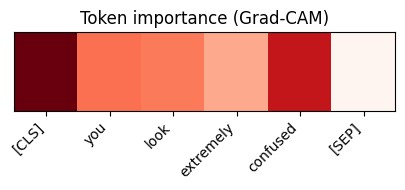

In [13]:
plot_token_importance(tokens, grad_sam_scores)

## SHAP

In [14]:
"""Implementation following https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html"""

def f(x):
    # Tokenize all strings in input
    tv = torch.tensor([tokenizer(v, truncation=True, 
                                 max_length=tokenizer.model_max_length, 
                                 padding="max_length")["input_ids"] for v in x], device=device) 
    
    # Fix padding stuff when input consist of several sentences
    attention_masks = torch.tensor([tokenizer(v, truncation=True, max_length=tokenizer.model_max_length, 
                                              padding="max_length")["attention_mask"] for v in x], device=device)
    
    # Get model prediction (logits) and return the positive class
    outputs = model(input_ids=tv, attention_mask=attention_masks)[0].detach().cpu().numpy()
    
    return np.array(outputs[:,1]) # Positive class logits

Attention masks isn't necessary when the input is one sentence.

When the input contains several sentences of different lengst, padding tokens must be added. 

Attention masks masks out padding tokens when calculating attention scores, so that only the actual input sentence is used.

In [15]:
f(sentences)

array([ 3.6635604, -3.145779 , -3.42177  ,  2.665551 , -2.9030216],
      dtype=float32)

In [16]:
explainer = shap.Explainer(f, tokenizer) 
shap_values = explainer(sentences, fixed_context=1)

PartitionExplainer explainer: 6it [00:39,  9.83s/it]                       


In [17]:
shap_values

.values =
array([array([-0.12959404,  0.56973533,  2.801136  , -0.14384766,  0.32744628,
               0.17642218])                                                   ,
       array([ 0.04401787,  0.0455354 , -3.53780532, -0.05805483,  0.00513351,
               0.29313171])                                                   ,
       array([ 0.30843814,  0.25726183,  0.28962787,  0.2899166 , -4.94576643,
               0.31648912])                                                   ,
       array([-0.10001755,  0.30019092,  1.07011425,  1.28322422,  0.11099588,
               0.42984878,  0.22122835, -0.22297741])                         ,
       array([ 0.59630405,  0.48589837,  0.2785713 , -0.05426295, -4.8373702 ,
               0.56557508])                                                   ],
      dtype=object)

.base_values =
array([ 0.06226253,  0.06226253,  0.06226253, -0.42705649,  0.06226253])

.data =
(array(['', 'I ', 'like ', 'the ', 'movie', ''], dtype=object), array(['', '

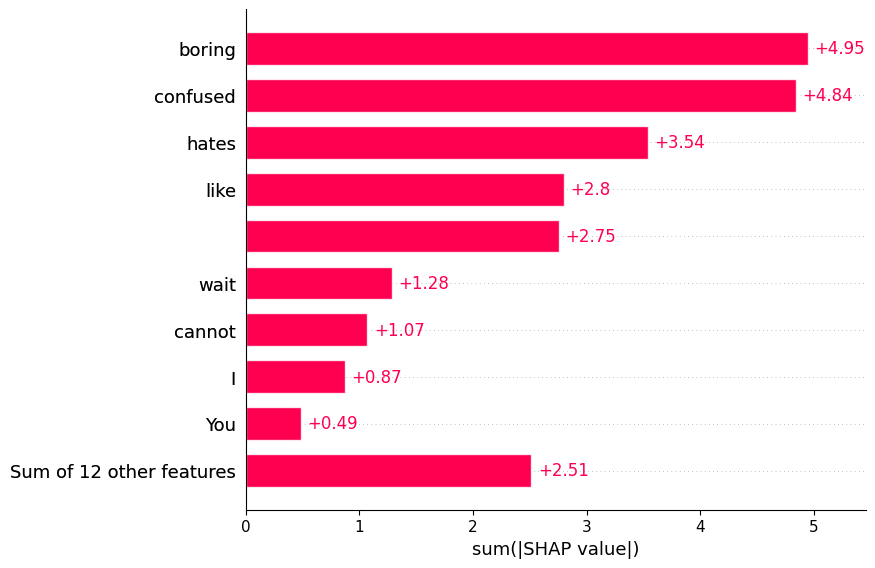

In [18]:
shap.plots.bar(shap_values.abs.sum(0))

In [19]:
i = 3
shap.plots.initjs()
shap.plots.text(shap_values[i])

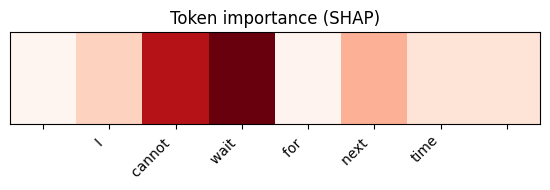

In [20]:
plot_token_importance(shap_values[i].data, np.abs(shap_values[i].values), title="Token importance (SHAP)")

## TCAV score

In [21]:
batch_size = 16
num_concept_images = 100
num_target_images = 20
target_class = "zebra"
positive_concept = "striped"
negative_concept = "dotted"

In [22]:
# Get the absolute path to concept and target images 
base_dir = os.getcwd()
concept_folder = "../data/broden/dtd"
target_folder = os.path.join("../data/imagenet", target_class)

p_concept_paths = select_concept_images(folder_path=concept_folder, concept=positive_concept, n=num_concept_images)
n_concept_paths = select_concept_images(folder_path=concept_folder, concept=negative_concept, n=num_concept_images)

target_paths = sample_images(folder_path=target_folder, n=num_target_images)

In [23]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
vit.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [24]:
label2id = vit.config.label2id
class_idx = label2id.get(target_class)

In [25]:
positive_loader = get_vit_dataloader(p_concept_paths, processor, batch_size=batch_size)
negative_loader = get_vit_dataloader(n_concept_paths, processor, batch_size=batch_size)
target_loader = get_vit_dataloader(target_paths, processor, batch_size=batch_size)

In [26]:
layer = vit.vit.encoder.layer[10]

In [27]:
positive_activations = flatten(get_activations(vit, positive_loader, device, layer))
negative_activations = flatten(get_activations(vit, negative_loader, device, layer))

In [28]:
cav = train_cav(positive_activations, negative_activations)

In [29]:
grads = flatten(get_grads(vit, target_loader, device, layer, target_idx=class_idx))
tcav_score = tcav(cav, grads)
print(f"TCAV score: {tcav_score}")

TCAV score: 0.95


## Attention weights

In [30]:
sentence = "I like the movie."

input = tokenize_input(tokenizer, sentence).to(device) # Return the tokenizer output for the input sentence, which includes the tokenized sentences with added CLS and SEP tokens and the attention masks 
output = model(**input, output_attentions=True) # Forward pass 
logits = output.logits 

# Get attention matrices for all heads and layers 
attentions = output.attentions # Tuple with tensor elements of shape (batch size, num attention heads, sequence length, sequence length), one tensor per layer (i.e., encoder block)


In [31]:
tokens = tokenizer.convert_ids_to_tokens(input["input_ids"][0])